Integration of datasets from different batches is often a central step in a single cell analysis pipeline. In this notebook we are going to use a conditional variational autoencoder (CVAE) to integrate a single-cell dataset with significant batch effects. As demonstrated by scVI ([Lopez 18](https://www.nature.com/articles/s41592-018-0229-2.epdf?author_access_token=5sMbnZl1iBFitATlpKkddtRgN0jAjWel9jnR3ZoTv0P1-tTjoP-mBfrGiMqpQx63aBtxToJssRfpqQ482otMbBw2GIGGeinWV4cULBLPg4L4DpCg92dEtoMaB1crCRDG7DgtNrM_1j17VfvHfoy1cQ%3D%3D)) CVAEs are very well suited for integration of single-cell data. By injecting the condition label into the encoder and decoder layer, the network is incentivized to only learn variation in the dataset that cannot be explained by the condition label.

In [1]:
import numpy as np
import scanpy as sc
import tensorflow.keras as keras
from sklearn import preprocessing as pp
from latent.models import NegativeBinomialVAE as NBVAE;

We import all necessary dependencies, including the `VariationalAutoencoder` from LatentLego. Now we load the dataset with `scanpy`. Here, we use the dataset used in [this scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html#Pancreas), since it contains strong batch effects and has been usen in various papers on data integration.

In [32]:
adata = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')
print(adata);

AnnData object with n_obs × n_vars = 14693 × 2448
    obs: 'celltype', 'sample', 'n_genes', 'batch', 'n_counts', 'louvain'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3'
    uns: 'celltype_colors', 'louvain', 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


## Data preprocessing
As a first step, we preprocess the data and visualize it using UMAP, so we can appreciate the batch effects.

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata);

Now we plot the UMAP representation of the data. 

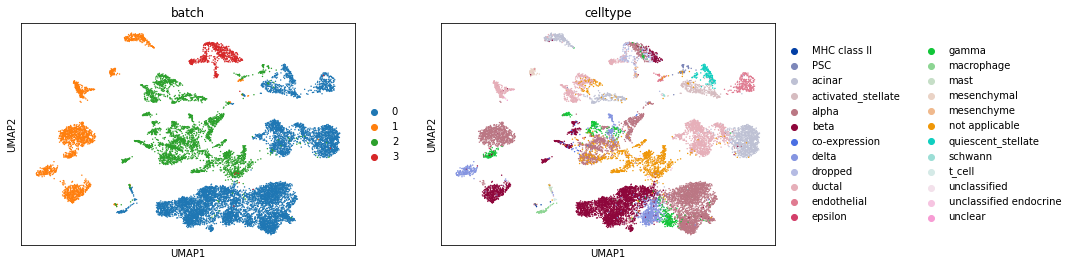

In [5]:
sc.pl.umap(adata, color=['batch', 'celltype'])

We can clearly see that a major part of the variation in this dataset is driven by batch and celltypes from different batches do not co-cluster at all. This is a good indicatior that integration of the different batches is necessary for downstream analysis. 

## Preparing the data
Currently, LatentLego is mostly an addon to TensorFlow/Keras and provides no interface to work with `AnnData` objects directly. I will probably add that in a future version though. For now, we have to extract and prepare the model inputs manually. 

In [6]:
# Select highly variable genes
highvar = adata.raw.var.index.isin(adata.var.index)
# Extract unscaled data
X_use = np.array(adata.raw.X[:, highvar].todense())

# Calculate size factors
n_umis = X_use.sum(1)
size_factors = n_umis / np.median(n_umis)

# Get batch label and format to one-hot encoded matrix
cond = adata.obs['batch'].values
le = pp.LabelEncoder()
cond = le.fit_transform(cond)
cond = keras.utils.to_categorical(cond)
print(cond)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## Fit the model
Now we prepare the model as well as a callback for early stopping and the optimizer. With `conditional = 'all'`, we tell the model to inject the condition in every hidden layer of the encoder and decoder networks. We also use a conditional version of the VAMP prior ([Tomczak 2017](https://arxiv.org/abs/1705.07120)) that has been shown to perform well on single cell data ([Dony 2020](https://icml-compbio.github.io/2020/papers/WCBICML2020_paper_37.pdf)).

In [16]:
# Initiate keras callback function and optimizer
es_callback = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Initiate autoencoder
autoencoder = NBVAE(
    x_dim = X_use.shape[1],
    encoder_units = [256, 128],
    decoder_units = [128, 256],
    latent_dim = 10,
    kld_weight = 1e-3,
    conditional = 'all',
    prior = 'vamp', 
    n_pseudoinputs = 50,
    dispersion = 'gene'
)
autoencoder.compile(optimizer=optimizer, run_eagerly=False)

Now we train the keras model the model (depending on where you are running this, this might take a while ;))

In [28]:
history = autoencoder.fit(
    [X_use, cond, size_factors],
    batch_size = 50,
    epochs = 100,
    use_multiprocessing = True,
    workers = 30,
    callbacks = [es_callback],
    verbose = False
);

Now we can use the `.transform()` method to obtain the latent representation. We'll add that to the `AnnData` object and use UMAP to further reduce it to 2D.

In [18]:
latent = autoencoder.transform([X_use, cond])
adata.obsm['X_ae'] = latent
sc.pp.neighbors(adata, use_rep='X_ae', n_neighbors=30)
sc.tl.umap(adata, min_dist=0.1, spread=0.5)

And plot the result:

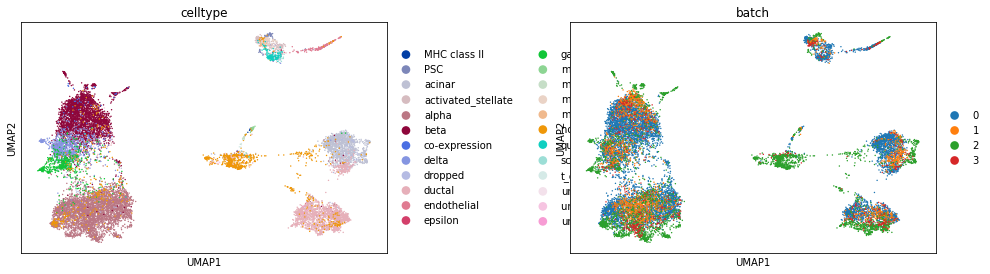

In [19]:
p = sc.pl.scatter(adata, show=False, basis='umap', color=['celltype', 'batch'])

We can see that the batches are integrated a lot better while preserving a good separation of celltypes. We can of course also use a 'regular' variational autoencoder with a standard normal prior. However, with the same weight of the KLD loss, the latent representation will be 'smoother' and the celltypes are less well separated.

In [26]:
# Initiate autoencoder
autoencoder = NBVAE(
    x_dim = X_use.shape[1],
    encoder_units = [256, 128],
    decoder_units = [128, 256],
    latent_dim = 10,
    kld_weight = 1e-3,
    conditional = 'all',
    dispersion = 'gene'
)
autoencoder.compile(optimizer=optimizer, run_eagerly=False)
history = autoencoder.fit(
    [X_use, cond, size_factors],
    batch_size = 50,
    epochs = 100,
    use_multiprocessing = True,
    workers = 30,
    callbacks = [es_callback],
    verbose = False
);

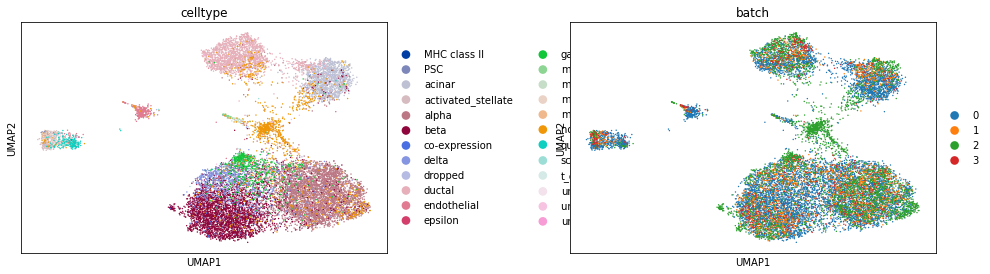

In [24]:
latent = autoencoder.transform([X_use, cond])
adata.obsm['X_ae'] = latent
sc.pp.neighbors(adata, use_rep='X_ae', n_neighbors=30)
sc.tl.umap(adata, min_dist=0.1, spread=0.5)
p = sc.pl.scatter(adata, show=False, basis='umap', color=['celltype', 'batch'])